![book header](pictures/header.png)

[Table of Contents](0_Table_of_Contents.ipynb)

# Module 4: Car Model
**Contents:**
* [Velocity Model](#velocity-model)
* [Steering Model](#steering-model)
* [Building a Unified Car Model](#building-a-unified-car-model)
* [Assessment](#assessment)


In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Uncomment one of the following lines depending on your setup

# If you are using the real car, uncomment the next line and comment the simulator line
# from serial import Serial

# If you are using the simulator, uncomment the next line and comment the real car line

# Note: After changing the import statement, you need to restart the kernel for changes to take effect.

In this Module, we give some basic ingredients to model KITT's behavior. The goal is to use this model to predict its
state (position, orientation, velocity) 1 to 2 seconds ahead of time. This will allow you to drive for some time before you receive a new localization estimate from Module 3.

This module is divided into two parts: a velocity model and a steering model. By the end of the module, you will have created Python code that simulates the car's movement based on a model of its physics, and calibrated by real-world data.

Using the velocity model, you will be able to predict the car's velocity based on the throttle and time. Using the steering model, you will be able to predict the car's orientation based on the steering wheel setting and time. This will enable you to plan what commands to send to the car to make it move to a desired location.

## Velocity Model

### Forces Acting on KITT

We start by driving on a straight line, and consider a simple model of longitudinal KITT dynamics,
described by Newton’s second law, $F=m a$. The car’s motion with mass $m$ is influenced by the following three forces:

- $F_{motor}$: The driving force provided by the motor.
- $F_{friction}$: The frictional force opposing the motion, which is proportional to the velocity, $F_{friction} = -b \, v$, where $b$ is the friction coefficient.
- $F_{{air}}$: The air resistance, which is proportional to the square of the velocity, $F_{{air}} = -c \, v^2$, where $c$ is the air resistance coefficient.

Assuming $v$ is positive, the net resulting force acting on the car can be expressed as:

$$ F_{{res}} = F_{{motor}} - b v - c v^2 $$


 <img src="pictures/KITTwind.jpg" alt="KITTwind" width="350px">

 *Indicate the forces and their directions.* 

Note that another force acting on the car could be the braking force $F_b$. 
Unfortunately, KITT does not have a brake! You can stop by letting KITT roll to standstill, or for a
short period apply a negative force $F_{motor}$. The difference with a real brake is that if you apply $F_{motor}$ for
too long, or were already stopped, the car will drive backwards.

### Newton's Second Law of Motion

According to Newton's second law, the net force acting on the car is equal to the mass of the car times its acceleration:

$$ F_{{res}} = m a = m \frac{{\mathrm d}v}{{\mathrm d}t} $$

Substituting the expression for $F_{res}$ gives

$$ m \frac{{\mathrm d}v}{{\mathrm d}t} = F_{{motor}} - b v - c v^2 $$

### Velocity as a Function of Time

To find the velocity as a function of time, we need to solve the differential equation:

$$ \frac{{\mathrm d}v}{{\mathrm d}t} = \frac{F_{{motor}}}{m} - \frac{b}{m} v - \frac{c}{m} v^2 $$

This is a nonlinear differential equation due to the $v^2$ term. However, if air resistance is small compared to friction, we can neglect the $ v^2$  term for a simplified model:

$$ \frac{{\mathrm d}v}{{\mathrm d}t} = \frac{F_{{motor}}}{m} - \frac{b}{m} v $$

The solution to this first-order linear differential equation is:

$$ v(t) = \frac{F_{{motor}}}{b} \left(1 - e^{-\frac{b}{m}t}\right) $$

This is of the form: $v(t) = A( 1 - e^{-t/\tau})$, where $\tau=m/b$ is a time constant, similar to the RC-time in an electric circuit, and $A$ is the final (constant) velocity that the car is able to reach.

_Exercise_: From this expression for $v(t)$, derive an expression for the position $x(t)$. You can also extend the solutions to take a nonzero initial velocity $v(0)$ and $x(0)$ into account.

### Implementing the Velocity Model
Now we will use the above equations to calculate the velocity of the car over time for a single value of the motor command $F_{motor}$. In the example simulation below, we assume some random car parameters, but note that these values are plausible but not accurate. Later, you will need to estimate these constants for your own car. For increased accuracy, you might even need to repeat this calibration for multiple battery values. 

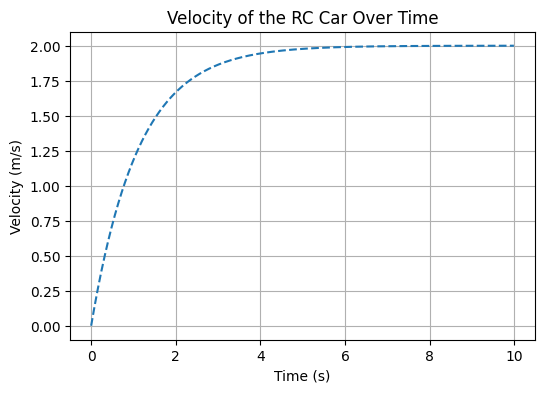

In [6]:
### Student Version ###
# Car parameters, set them to the real values
# You can use these random values until you measure the real ones
m = 5.6  # actual mass of the car (kg)
b = 5.0  # random friction coefficient (N·s/m)

# motor command
F_motor = 10.0  # random constant motor force (N)

# simulation parameters
dt = 0.01  # time step (s)
t_max = 10.0  # maximum simulation time (s)
t = np.arange(0, t_max, dt) # Time array between 0 and t_max with time step dt

# Velocity array
v = np.zeros_like(t) # Empty array to store the velocity values
v[0] = 0.0  # initial velocity (m/s)

# Numerical simulation (Euler's method)
for i in range(1, len(t)):
    # TODO: Implement the model without air resistance (c=0) straight from the differential equation
    dv = (F_motor - b * v[i-1])/m
    v[i] = v[i-1] + dv*dt

# Plotting the results
plt.figure(figsize=(6, 4))
plt.plot(t, v, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity of the RC Car Over Time')
plt.grid(True)
plt.show()

### Calibrating the Velocity Model

In this section, you will try to estimate the parameters $F_{motor}$ and $b$ from measured data. The mass of the car was weighed and is $m=5.6$ kg. To find the other parameters, we will closely examine the velocity equation and write some code to make measurements on the car. This part is less guided so you will have to find some of your own solutions. 

Recall that the velocity equation (zero initial conditions) is

$$ v(t) = \frac{F_{{motor}}}{b} \left(1 - e^{-\frac{b}{m}t}\right) $$

Note that for sufficiently large $t$, we see that the velocity becomes constant: $v(\infty) = \frac{F_{{motor}}}{b}$. This is called the terminal velocity.

#### Finding the Friction Coefficient $b$

1. **Measure Terminal Velocity:**
   - Run the car at a motor command setting of interest towards a wall. Measure the velocity as the car accelerates until $v_{\infty}$ is reached. For this you can use the distance sensors. _Please place one of the bumber boxes in front of the car to stop it from crashing into the wall._ Transform these distance measurements into a velocity plot (remove duplicates and merge the L and R sensor data, as done in Module 2). Plot both position and velocity as function of time.
   
2. **Initial Acceleration:**
   - At the very beginning of the motion, the car starts from rest, and the initial velocity $v(0) = 0$. At this point, frictional forces are negligible since $v$ is small, and the acceleration ${\mathrm d}v/{\mathrm d}t$ can be approximated by
     $$ \frac{{\mathrm d}v}{{\mathrm d}t} \approx \frac{F_{{motor}}}{m} $$
   - You can estimate this value from the slope of the $v(t)$ plot near $t=0$. Assuming we know $m$, we find an estimate for $F_{motor}$.

3. **Calculate $b$ Using Terminal Velocity:**
   - With $F_{{motor}}$ known, use the measured terminal velocity $v_\infty$ to calculate the friction coefficient $b$:
     $$ b = \frac{F_{{motor}}}{v_{{\infty}}} $$

The above process is just one approach. Using measured data, it might be less accurate because it requires you to make a velocity plot (taking numerical derivatives magnifies noise) and then even a second derivative (the slope of $v(t)$). Alternatively, you can work with a plot of position vs time, and measure the terminal velocity as the slope of the $x(t)$ plot for larger time. The time constant $\tau = m/b$ can be determined from a velocity plot by marking the time where the velocity is $1/e \approx 0.368$ of its final value. 

- Once you have estimated your parameters, plot the resulting model curves (for velocity and position) on top of the measured curves. Comment on these plots: how well is the fitting?

- $F_{{motor}}$ depends on the speed setting, and also on the battery status; it will have to be measured again if these values change. For your application, you probably need only one or two speed settings, but you can try to make a calibration table for multiple battery levels.


- The value of $b$ should be independent of the speed setting. If you have a calibration table, can you verify this? If it appears constant, you could use an average $b$ for improved accuracy, rather than a separate $b$ for each speeed setting.

#### Finding the response time

As you try to fit the theoretical first order model for $x(t)$ to your measured data, you will probably find that the model is not complete: between giving a speed command and the car responding is a rather large reponse time $t_0$, which delays the theoretical response to $x(t-t_0)$. 

Try to estimate $t_0$ and investigate if this parameter allows you to make a better fit. 

### Model for driving backwards

You don't always drive at full speed, occasionally you also will want to stop the car. There are 2 options for this: setting the speed to neutral (150) and letting the car roll to standstill, or briefly set the motor speed to drive backwards. The first option is simpler to model because the second one has multiple parameters that you need to set (and they might be dependent on your current speed); however, the second one is probably also much faster and perhaps more accurate.

Choose one of these two methods and create a model for it, with as input the initial velocity $v(0)$, where $t=0$ is the time you set the speed to neutral or decide to drive backwards. What parameters need to be calibrated? For the rest, the implementation of this model is not that different than the model that you already have. 

Show plots to show how well your model for $x(t)$ fits measured data.
In the end, the model needs to tell you how far the car will drive, i.e. $x(\infty)$.

### Combined model for driving straight

Implement your model into a function, or better still, a `class` object. The function should take as input a driving command and a time duration, and have a loop that integrates the differential equation over small time steps to the requested time. The `class` wrapper around it contains state parameters such as current time, position, and velocity, and update the state to the requested time.  

The implementation of the response time might be a bit more tricky: you also need to have the current speed setting as part of the state, and if the newly requested speed setting is different, switch to the new setting at the appropriate moment (integrating using the old setting until that moment).

**Jump ahead to the section below: "Building a Unified Car Model",** to see how we envision you can build your model class.
Here, you can skip the parts that have to do with steering. 






## Mid-term Assessment and Report

Ultimately in Week 5, you will showcase the functionality of your 1D car model to your assigned TA. 
The TA will give you a short series of driving commands (e.g., M165 for 1.5 sec, M150), your model predicts the final position, and this is compared to the actual position of KITT after following the same series of commands.

In the midterm report, present the model, and present test results that shows the accuracy of this model,
starting from a known state. Summarize in a conclusion: over what time period can you predict the new
position of the car with an accuracy better than 30 cm?

## After the Mid-term: Steering Model

To model the steering behavior of a 4-wheeled car, often the Ackermann steering model is used. However, we will work with a simplified version that models the steering of a bicycle. 

### The Bicycle Steering Geometry


Consider the following figure:

<img src="pictures/bicycle.png" alt="Bicycle Steering Model" width="600" />

In this figure, we have
- $\theta$: the heading (or orientation) of the car
- $\delta$: the steering angle (you determine this by a steering command)
- $L$: the wheel base
- $R$: the radius of the turning circle
- $\omega = {\mathrm d}\theta / {\mathrm d} t$: rate of angle change (or angular velocity) 

We choose to measure $R$ with respect to the rear axle. From the geometry, we can then derive the following two equations:
- $\frac{L}{R} = \tan(\delta) \qquad \Rightarrow \quad R = \frac{L}{\tan(\delta)}$
- $\omega = \frac{v}{R}$

To verify this equation, consider that we drive with a constant velocity over an entire circle (rotation angle $2\pi$, circumference $2 \pi R$, driving time $T$):
- $\omega T = 2\pi \quad \Rightarrow \quad \omega = \frac{2\pi}{T}$
- $2\pi R = v T \quad \Rightarrow \quad \omega = \frac{2\pi}{2\pi R}\cdot v = \frac{v}{R}$ 

The expression $R = L/\tan(\delta)$ can be used to create a calibration table: for various steering commands, we measure the resulting $R$ and compute the corresponding $\delta$. If we then apply a new (uncalibrated) angle setting, we can interpolate the table to find $\delta$ and then calculate the corresponding radius $R$.

The expression for $\omega$ will be useful in our implementation of the car model where we integrate over small time steps $\Delta t$.

In [4]:
### Student Version ###
# Car Parameters
L = 0.335  # Wheelbase (meters)
R = 1.5    # Measured turning radius (meters) for some steering command

# TODO: Calculate the steering angle delta based on the bicycle model
delta = 

# Convert to degrees for easier interpretation
delta_deg = np.degrees(delta)

print(f"Steering Angle: {delta_deg:.2f} degrees")

SyntaxError: invalid syntax (3356480960.py, line 7)

## Building a Unified Car Model

In this section, you will integrate the velocity model and a steering model into a single, unified Python class. For this you will create all sections step-by-step and later combine them into a single class to re-use in your main code.

### Step 1: Setting Up the Car’s Physical Properties

To begin, we need to define the physical properties of KITT. These include its mass, friction coefficient, and motor force. These properties will be used in our calculations. Later, you add a calibration table to translate a speed setting to the corresponding motor force.

In [ ]:
### Student Version ###
# TODO: Step 1: Define the physical properties of the RC car
mass = 5.6  # kg, mass of the car
wheelbase = 0.335  # m, distance between the front and rear axles
friction_coefficient = # N·s/m, resistance due to friction
motor_force = # N, force generated by the motor for certain speed setting (should later be set from a calibration table)

### Step 2: Initializing the Car’s State

Next, we need to define and initialize the state of the car. The state includes the car’s position, velocity, orientation, and the current time. Before the mid-term, we will store the position as a 1D coordinate $x$, and later extend it to a 2D coordinate $[x, y]$. The velocity is a scalar (speed in meters per second), the orientation is an angle (in radians), and time is a scalar (seconds).  _In this chapter, the position of the car refers to the center of the rear axle. At some point, you have to translate this to a more useful reference point, i.e. the center of the beacon._

In [ ]:
# Step 2: Initialize the car's state
position = np.array([0.0, 0.0])  # (x, y) position in meters
velocity = 0.0  # initial speed in m/s
orientation = 0.0  # initial orientation in radians (0 means facing along the x-axis)
time = 0.0  # start time in seconds; position, velocity and orientation refer to this time

### Step 3: Updating the Car’s Velocity

KITT's velocity depends on the force applied by the motor, as well as the friction and air resistance. You have already derived the equation for updating the current velocity $v[i]$:

$$ a[i] = \frac{F_{{motor}}}{m} - \frac{b}{m} v[i]$$

so that

$$ v[i+1] = v[i] + a[i] \cdot \Delta t$$

We can now implement this equation as a function in Python:

In [ ]:
### Student Version ###
# TODO: Step 3: Define a function to update the car's velocity
def update_velocity(velocity, F_motor, mass, friction_coefficient, dt):
    # TODO: Calculate acceleration
    acceleration = 
    # TODO: Update velocity
    velocity += 
    return velocity


### Step 4: Updating the Car’s Orientation

The car’s orientation changes based on the turn radius. The bicycle steering model helps us determine how much the car’s orientation should change given the current velocity and turning radius.

The change in orientation can be calculated as:

$$ \omega = \frac{v}{R}$$

$$ \Delta \theta =  \omega\cdot \Delta t $$

so that

$$ \theta[i+1] = \theta[i] + \Delta\theta$$

In [ ]:
### Student Version ###
# TODO: Step 4: Define a function to update the car's orientation
def update_orientation(orientation, velocity, turn_radius, dt):

    return orientation

### Step 5: Updating the Car’s Position

The car’s position changes based on its velocity and orientation. Let's store the position in a 2D vector $\mathbf z$. We can use basic trigonometry to update the position:


$$ {\mathbf z}[i+1] = {\mathbf z}[i] + v[i] \cdot\Delta t \cdot [\cos(\theta[i]), \sin(\theta[i])] $$

In [ ]:
### Student Version ###
# TODO: Step 5: Define a function to update the car's position
def update_position(position, velocity, orientation, dt):
    position[0] += # Update x-coordinate
    position[1] += # Update y-coordinate
    return position

### Step 6: Integrating Everything into a Car Class

Now that you have functions to update each part of the car’s state, it’s convenient to integrate everything into a single class. This class will manage the car’s state and provide an easy interface to simulate its movement.

In [ ]:
### Student Version ###
# TODO: Step 6: Create the KITT_Dynamics class
class KITT_Dynamics:
    def __init__(self, mass, wheelbase, friction_coefficient, motor_force):
        # Physical properties of the car
        self.mass = mass
        self.wheelbase = wheelbase
        self.friction_coefficient = friction_coefficient
        self.motor_force = motor_force
        
        # Initial state
        self.position = np.array([0.0, 0.0])  # (x, y) position
        self.velocity = 0.0  # initial velocity in m/s
        self.orientation = 0.0  # initial orientation in radians
        self.time = 0.0  # start time in seconds
        
    def update(self, motor_on, turn_radius, dt):
        # Determine the motor force
        F_motor = self.motor_force if motor_on else 0.0
        
        # Update the car's state
        self.velocity = update_velocity(self.velocity, F_motor, self.mass, self.friction_coefficient, dt)
        self.orientation = update_orientation(self.orientation, self.velocity, turn_radius, dt)
        self.position = update_position(self.position, self.velocity, self.orientation, dt)
        
        # Update time
        self.time += dt
    
    def get_state(self):
        return {
            'position': self.position,
            'velocity': self.velocity,
            'orientation': self.orientation,
            'time': self.time
        }
    
    @staticmethod
    # TODO: Step 3: Define a function to update the car's velocity
    def update_velocity(velocity, F_motor, mass, friction_coefficient, dt):
        # TODO: Calculate acceleration
        acceleration = 
        # TODO: Update velocity
        velocity += 
        return velocity
    
    @staticmethod
    # TODO: Step 4: Define a function to update the car's orientation
    def update_orientation(orientation, velocity, turn_radius, dt):

        return orientation
    
    @staticmethod
    # TODO: Step 5: Define a function to update the car's position
    def update_position(position, velocity, orientation, dt):
        position[0] += # Update x-coordinate
        position[1] += # Update y-coordinate
        return position

### Step 7: Running the Simulation

With the car model complete, you can now simulate the car’s movement over time. We do this by computing the position of the car in steps of dt, storing the positions in an array, and finally plotting them.

In [ ]:
# Step 7: Simulate the car's motion
dt = 0.01  # time step (s)
simulation_time = 10.0  # total simulation time (s)
turn_radius = 1.0  # turn radius in meters (positive for right, negative for left)

# Initialize the car model
car = KITT_Dynamics(mass, wheelbase, track_width, friction_coefficient, motor_force)

# Arrays to store the simulation data
positions = []
velocities = []
orientations = []
times = []

# Run the simulation
for t in np.arange(0, simulation_time, dt):
    if t < 5.0:
        car.update(motor_on=True, turn_radius=turn_radius, dt=dt)
    else:
        car.update(motor_on=False, turn_radius=0, dt=dt)
    state = car.get_state()
    
    positions.append(state['position'].copy())
    velocities.append(state['velocity'])
    orientations.append(state['orientation'])
    times.append(state['time'])
    
# Convert to numpy arrays for easier plotting
positions = np.array(positions)
velocities = np.array(velocities)
orientations = np.array(orientations)
times = np.array(times)

# Plotting the car's path with color gradient based on time
plt.figure(figsize=(6, 4))
sc = plt.scatter(positions[:, 0], positions[:, 1], c=times, cmap='viridis', label="Car Path", s=5)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Path Over Time")
plt.axis('equal')
plt.grid(True)
plt.colorbar(sc, label="Time (s)")
plt.show()

# Plotting the car's velocity over time
plt.figure(figsize=(6, 4))
plt.plot(times, velocities, label="Velocity (m/s)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Over Time")
plt.grid(True)
plt.legend()
plt.show()

The scripts shown above are able to create realistic car tracks. However, they need to be extended/adjusted by you to take into account:
- translation of your speed setting command to a corresponding $F_{{motor}}$ (calibration table)
- translation of your steering setting command to a corresponding turning circle $R$ (calibration table / interpolation function)
- translation of the internally tracked position (mid of real axle) to a better reference point (car beacon)
- nonzero initial conditions

At some point you will probably find that the car behavior is not constant; e.g., the velocity response depends on the battery status and also (slightly) on the steering setting. You could extend your model to take that into account.